<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = True
CLAHE = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/sample_data/ham

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)


      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [6]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  print((1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]))
  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

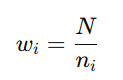

In [7]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [8]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.CrossEntropyLoss(pos_weight=pos_weight)

    num_features = efficientnetmulticlass.fc.in_features
    efficientnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return efficientnet,loss_fn



In [9]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [10]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [11]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [12]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.017
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [13]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [14]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)
    clean_img = torch.tensor(clean_img)

    imatge,label = train_data.__getitem__(i)

    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'resnet152'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    # transforms.RandomGrayscale(p = 0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

CLAHE = True
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 60
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 5:
  weights = binary_weights
else:
  weights = multiple_weights


learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":weights,
                "CLAHE": CLAHE,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
2.845929572315279


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 227MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 60, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': 2.845929572315279, 'CLAHE': True}


  0%|          | 0/60 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.636496510044987
Accuracy train epoch: 1  train_acc: 0.7564741035856574
F1 train epoch: 1  train_f1: 0.7803425758117636
Recall train epoch: 1  train_recall: 0.7564741035856574


Pèrdua validació epoch: 1  val_loss: 0.488741971552372
Accuracy val epoch: 1  val_acc: 0.86015625
F1 val epoch: 1  val_f1: 0.8620904397196328
Recall val epoch: 1  val_recall: 0.86015625
Recall val epoch: 1  val_precision: 0.8749316118219334


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.48232549903877225
Accuracy train epoch: 2  train_acc: 0.8517634009416878
F1 train epoch: 2  train_f1: 0.8637384715678951
Recall train epoch: 2  train_recall: 0.8517634009416878


Pèrdua validació epoch: 2  val_loss: 0.4330459332559258
Accuracy val epoch: 2  val_acc: 0.853515625
F1 val epoch: 2  val_f1: 0.8628078588124725
Recall val epoch: 2  val_recall: 0.853515625
Recall val epoch: 2  val_precision: 0.8839630270375006


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.4090440479289013
Accuracy train epoch: 3  train_acc: 0.8761318362911988
F1 train epoch: 3  train_f1: 0.8851626680753297
Recall train epoch: 3  train_recall: 0.8761318362911988


Pèrdua validació epoch: 3  val_loss: 0.4047397819813341
Accuracy val epoch: 3  val_acc: 0.8765625
F1 val epoch: 3  val_f1: 0.8806208584062742
Recall val epoch: 3  val_recall: 0.8765625
Recall val epoch: 3  val_precision: 0.8933958193514947


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3448766399011669
Accuracy train epoch: 4  train_acc: 0.8991647048170952
F1 train epoch: 4  train_f1: 0.9058410342181915
Recall train epoch: 4  train_recall: 0.8991647048170952


Pèrdua validació epoch: 4  val_loss: 0.42580813891254365
Accuracy val epoch: 4  val_acc: 0.8814453125
F1 val epoch: 4  val_f1: 0.8788307959996788
Recall val epoch: 4  val_recall: 0.8814453125
Recall val epoch: 4  val_precision: 0.8942960459163315


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.297084719536314
Accuracy train epoch: 5  train_acc: 0.9158479717493662
F1 train epoch: 5  train_f1: 0.9216233300202977
Recall train epoch: 5  train_recall: 0.9158479717493662


Pèrdua validació epoch: 5  val_loss: 0.40984243527054787
Accuracy val epoch: 5  val_acc: 0.8677734375
F1 val epoch: 5  val_f1: 0.8740362292101366
Recall val epoch: 5  val_recall: 0.8677734375
Recall val epoch: 5  val_precision: 0.8941185554929537


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.2645872979465709
Accuracy train epoch: 6  train_acc: 0.9266796450561391
F1 train epoch: 6  train_f1: 0.9313660612393007
Recall train epoch: 6  train_recall: 0.9266796450561391


Pèrdua validació epoch: 6  val_loss: 0.42065938003361225
Accuracy val epoch: 6  val_acc: 0.8984375
F1 val epoch: 6  val_f1: 0.898952221690929
Recall val epoch: 6  val_recall: 0.8984375
Recall val epoch: 6  val_precision: 0.903752902105081


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.24432481586398833
Accuracy train epoch: 7  train_acc: 0.9340252625860196
F1 train epoch: 7  train_f1: 0.9382022545882978
Recall train epoch: 7  train_recall: 0.9340252625860196


Pèrdua validació epoch: 7  val_loss: 0.43633640464395285
Accuracy val epoch: 7  val_acc: 0.897265625
F1 val epoch: 7  val_f1: 0.899083426437933
Recall val epoch: 7  val_recall: 0.897265625
Recall val epoch: 7  val_precision: 0.909859434908263


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.225577611832386
Accuracy train epoch: 8  train_acc: 0.9400013582035495
F1 train epoch: 8  train_f1: 0.943792600912914
Recall train epoch: 8  train_recall: 0.9400013582035495


Pèrdua validació epoch: 8  val_loss: 0.4128811223199591
Accuracy val epoch: 8  val_acc: 0.9130859375
F1 val epoch: 8  val_f1: 0.9120419796879499
Recall val epoch: 8  val_recall: 0.9130859375
Recall val epoch: 8  val_precision: 0.9199873986254306


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.1761137875635548
Accuracy train epoch: 9  train_acc: 0.9528137450199203
F1 train epoch: 9  train_f1: 0.9556029878663859
Recall train epoch: 9  train_recall: 0.9528137450199203


Pèrdua validació epoch: 9  val_loss: 0.47804790711961687
Accuracy val epoch: 9  val_acc: 0.9052734375
F1 val epoch: 9  val_f1: 0.9046488480232567
Recall val epoch: 9  val_recall: 0.9052734375
Recall val epoch: 9  val_precision: 0.9122560406605982


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.1655979150928468
Accuracy train epoch: 10  train_acc: 0.9559376131836291
F1 train epoch: 10  train_f1: 0.9583782291252377
Recall train epoch: 10  train_recall: 0.9559376131836291


Pèrdua validació epoch: 10  val_loss: 0.5197149240411818
Accuracy val epoch: 10  val_acc: 0.9029296875
F1 val epoch: 10  val_f1: 0.9015525451505668
Recall val epoch: 10  val_recall: 0.9029296875
Recall val epoch: 10  val_precision: 0.906085844356992


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.14653329672180562
Accuracy train epoch: 11  train_acc: 0.9611553784860558
F1 train epoch: 11  train_f1: 0.9635661145103055
Recall train epoch: 11  train_recall: 0.9611553784860558


Pèrdua validació epoch: 11  val_loss: 0.5558249985333532
Accuracy val epoch: 11  val_acc: 0.91484375
F1 val epoch: 11  val_f1: 0.9132262596366003
Recall val epoch: 11  val_recall: 0.91484375
Recall val epoch: 11  val_precision: 0.921790111358297


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.14629668136131005
Accuracy train epoch: 12  train_acc: 0.9602951829047447
F1 train epoch: 12  train_f1: 0.9624996983298432
Recall train epoch: 12  train_recall: 0.9602951829047447


Pèrdua validació epoch: 12  val_loss: 0.5842963573522866
Accuracy val epoch: 12  val_acc: 0.9091796875
F1 val epoch: 12  val_f1: 0.9062986063607966
Recall val epoch: 12  val_recall: 0.9091796875
Recall val epoch: 12  val_precision: 0.9173585063563513


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.11974460265016651
Accuracy train epoch: 13  train_acc: 0.969746015936255
F1 train epoch: 13  train_f1: 0.9713384422905479
Recall train epoch: 13  train_recall: 0.969746015936255


Pèrdua validació epoch: 13  val_loss: 0.5217743185348809
Accuracy val epoch: 13  val_acc: 0.912109375
F1 val epoch: 13  val_f1: 0.9098504276733212
Recall val epoch: 13  val_recall: 0.912109375
Recall val epoch: 13  val_precision: 0.9163601912771834


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.1066292008548322
Accuracy train epoch: 14  train_acc: 0.9744884099963781
F1 train epoch: 14  train_f1: 0.9756305261826018
Recall train epoch: 14  train_recall: 0.9744884099963781


Pèrdua validació epoch: 14  val_loss: 0.5637959910091013
Accuracy val epoch: 14  val_acc: 0.9080078125
F1 val epoch: 14  val_f1: 0.905778126141343
Recall val epoch: 14  val_recall: 0.9080078125
Recall val epoch: 14  val_precision: 0.9145067772069507


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.11103163458651814
Accuracy train epoch: 15  train_acc: 0.9731188880840275
F1 train epoch: 15  train_f1: 0.9745707613843597
Recall train epoch: 15  train_recall: 0.9731188880840275


Pèrdua validació epoch: 15  val_loss: 0.6245154174976051
Accuracy val epoch: 15  val_acc: 0.909765625
F1 val epoch: 15  val_f1: 0.905315283660969
Recall val epoch: 15  val_recall: 0.909765625
Recall val epoch: 15  val_precision: 0.914677535274607


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.08993290161780745
Accuracy train epoch: 16  train_acc: 0.9773519558131112
F1 train epoch: 16  train_f1: 0.9784248959267171
Recall train epoch: 16  train_recall: 0.9773519558131112


Pèrdua validació epoch: 16  val_loss: 0.5278589926310815
Accuracy val epoch: 16  val_acc: 0.9166015625
F1 val epoch: 16  val_f1: 0.9154321811992436
Recall val epoch: 16  val_recall: 0.9166015625
Recall val epoch: 16  val_precision: 0.9246441555864887


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.09914100254733724
Accuracy train epoch: 17  train_acc: 0.9747260956175299
F1 train epoch: 17  train_f1: 0.9761849685991207
Recall train epoch: 17  train_recall: 0.9747260956175299


Pèrdua validació epoch: 17  val_loss: 0.545945301419124
Accuracy val epoch: 17  val_acc: 0.905859375
F1 val epoch: 17  val_f1: 0.9065128168912125
Recall val epoch: 17  val_recall: 0.905859375
Recall val epoch: 17  val_precision: 0.9137929980942069


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.08180236607322476
Accuracy train epoch: 18  train_acc: 0.9803286852589641
F1 train epoch: 18  train_f1: 0.9814789994124751
Recall train epoch: 18  train_recall: 0.9803286852589641


Pèrdua validació epoch: 18  val_loss: 0.6118466088082641
Accuracy val epoch: 18  val_acc: 0.9169921875
F1 val epoch: 18  val_f1: 0.913453585740895
Recall val epoch: 18  val_recall: 0.9169921875
Recall val epoch: 18  val_precision: 0.9213678619819177


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.09366515801618418
Accuracy train epoch: 19  train_acc: 0.9770916334661355
F1 train epoch: 19  train_f1: 0.9784411338580439
Recall train epoch: 19  train_recall: 0.9770916334661355


Pèrdua validació epoch: 19  val_loss: 0.6247944682836533
Accuracy val epoch: 19  val_acc: 0.9068359375
F1 val epoch: 19  val_f1: 0.9047052207017876
Recall val epoch: 19  val_recall: 0.9068359375
Recall val epoch: 19  val_precision: 0.9104610691905278


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.0886045612238971
Accuracy train epoch: 20  train_acc: 0.9783366533864541
F1 train epoch: 20  train_f1: 0.9793624616512498
Recall train epoch: 20  train_recall: 0.9783366533864541


Pèrdua validació epoch: 20  val_loss: 0.5245204648235813
Accuracy val epoch: 20  val_acc: 0.9189453125
F1 val epoch: 20  val_f1: 0.9169488560676357
Recall val epoch: 20  val_recall: 0.9189453125
Recall val epoch: 20  val_precision: 0.9201293591222772


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.06230631516133231
Accuracy train epoch: 21  train_acc: 0.9841882470119522
F1 train epoch: 21  train_f1: 0.9850803266522091
Recall train epoch: 21  train_recall: 0.9841882470119522


Pèrdua validació epoch: 21  val_loss: 0.5729558936727699
Accuracy val epoch: 21  val_acc: 0.9146484375
F1 val epoch: 21  val_f1: 0.9095825915157796
Recall val epoch: 21  val_recall: 0.9146484375
Recall val epoch: 21  val_precision: 0.9163354862520757


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.06752562517600795
Accuracy train epoch: 22  train_acc: 0.9835657370517928
F1 train epoch: 22  train_f1: 0.9843915952922531
Recall train epoch: 22  train_recall: 0.9835657370517928


Pèrdua validació epoch: 22  val_loss: 0.6446962532936595
Accuracy val epoch: 22  val_acc: 0.9208984375
F1 val epoch: 22  val_f1: 0.9180895429755734
Recall val epoch: 22  val_recall: 0.9208984375
Recall val epoch: 22  val_precision: 0.923499049884655


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.06950794095989776
Accuracy train epoch: 23  train_acc: 0.9831922310756972
F1 train epoch: 23  train_f1: 0.9840147405830432
Recall train epoch: 23  train_recall: 0.9831922310756972


Pèrdua validació epoch: 23  val_loss: 0.5238855849966058
Accuracy val epoch: 23  val_acc: 0.921875
F1 val epoch: 23  val_f1: 0.9216577838821447
Recall val epoch: 23  val_recall: 0.921875
Recall val epoch: 23  val_precision: 0.9272762359044748


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.07262570213199968
Accuracy train epoch: 24  train_acc: 0.9819585295182904
F1 train epoch: 24  train_f1: 0.9831715374719601
Recall train epoch: 24  train_recall: 0.9819585295182904


Pèrdua validació epoch: 24  val_loss: 0.5390808673691936
Accuracy val epoch: 24  val_acc: 0.908203125
F1 val epoch: 24  val_f1: 0.9070334434916456
Recall val epoch: 24  val_recall: 0.908203125
Recall val epoch: 24  val_precision: 0.9116852367517441


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.05982653315891456
Accuracy train epoch: 25  train_acc: 0.985308764940239
F1 train epoch: 25  train_f1: 0.9861725255345213
Recall train epoch: 25  train_recall: 0.985308764940239


Pèrdua validació epoch: 25  val_loss: 0.5598434363491833
Accuracy val epoch: 25  val_acc: 0.9130859375
F1 val epoch: 25  val_f1: 0.9103945365345162
Recall val epoch: 25  val_recall: 0.9130859375
Recall val epoch: 25  val_precision: 0.9157247194646388


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.04251647464545125
Accuracy train epoch: 26  train_acc: 0.9907868525896414
F1 train epoch: 26  train_f1: 0.991293445951269
Recall train epoch: 26  train_recall: 0.9907868525896414


Pèrdua validació epoch: 26  val_loss: 0.5974456168914912
Accuracy val epoch: 26  val_acc: 0.9255859375
F1 val epoch: 26  val_f1: 0.9209575820925241
Recall val epoch: 26  val_recall: 0.9255859375
Recall val epoch: 26  val_precision: 0.9302672234910582


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.05246085704367356
Accuracy train epoch: 27  train_acc: 0.9876856211517566
F1 train epoch: 27  train_f1: 0.9884183271776267
Recall train epoch: 27  train_recall: 0.9876856211517566


Pèrdua validació epoch: 27  val_loss: 0.594511998075177
Accuracy val epoch: 27  val_acc: 0.9267578125
F1 val epoch: 27  val_f1: 0.9242168591699901
Recall val epoch: 27  val_recall: 0.9267578125
Recall val epoch: 27  val_precision: 0.9285893944554167


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.04861962743775095
Accuracy train epoch: 28  train_acc: 0.9874252988047809
F1 train epoch: 28  train_f1: 0.9880476847164089
Recall train epoch: 28  train_recall: 0.9874252988047809


Pèrdua validació epoch: 28  val_loss: 0.6095419095363468
Accuracy val epoch: 28  val_acc: 0.9138671875
F1 val epoch: 28  val_f1: 0.9114576094082142
Recall val epoch: 28  val_recall: 0.9138671875
Recall val epoch: 28  val_precision: 0.9198694990111783


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.05686727380639766
Accuracy train epoch: 29  train_acc: 0.9858180912712785
F1 train epoch: 29  train_f1: 0.9866874011487785
Recall train epoch: 29  train_recall: 0.9858180912712785


Pèrdua validació epoch: 29  val_loss: 0.6065624330367427
Accuracy val epoch: 29  val_acc: 0.923828125
F1 val epoch: 29  val_f1: 0.9224878573727339
Recall val epoch: 29  val_recall: 0.923828125
Recall val epoch: 29  val_precision: 0.9288319154739256


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.05206873933914529
Accuracy train epoch: 30  train_acc: 0.987300796812749
F1 train epoch: 30  train_f1: 0.9878846464756613
Recall train epoch: 30  train_recall: 0.987300796812749


Pèrdua validació epoch: 30  val_loss: 0.654803786193952
Accuracy val epoch: 30  val_acc: 0.9185546875
F1 val epoch: 30  val_f1: 0.9151632158392254
Recall val epoch: 30  val_recall: 0.9185546875
Recall val epoch: 30  val_precision: 0.922108594268818
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


<ipython-input-13-40d8a7b82253>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


train/train_acc,▁▄▅▅▆▆▆▆▇▇▇▇▇█▇███████████████
train/train_f1,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇█▇█████████████
train/train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇█▇▇██████████
train/train_recall,▁▄▅▅▆▆▆▆▇▇▇▇▇█▇███████████████
val/val_acc,▂▁▃▄▂▅▅▇▆▆▇▆▇▆▆▇▆▇▆▇▇▇█▆▇██▇█▇
val/val_f1,▁▁▃▃▂▅▅▇▆▅▇▆▆▆▆▇▆▇▆▇▆▇█▆▆██▇█▇
val/val_loss,▃▂▁▂▁▁▂▁▃▄▅▆▄▅▇▄▅▇▇▄▆█▄▅▅▆▆▇▇█
val/val_precision,▁▂▃▃▃▅▅▇▆▅▇▆▆▆▆▇▆▇▅▇▆▇█▆▆██▇█▇
val/val_recall,▂▁▃▄▂▅▅▇▆▆▇▆▇▆▆▇▆▇▆▇▇▇█▆▇██▇█▇
train/train_acc,0.9873
